# Forest Cover Classification Using Decision Tree

In [118]:
# Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [119]:
# Reading the dataset
data_set = pd.read_csv("covtype.csv")
data_set.shape

(581012, 55)

In [120]:
# Separating the input features and target variable
X = data_set.iloc[:, :-1]
y = data_set['Cover_Type']

In [121]:
# Checking for missing values
missing_values = X.isnull().sum().sum()
print("Number of missing values in the dataset:",missing_values)

Number of missing values in the dataset: 0


In [122]:
# Normalizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [123]:
# Splitting the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [124]:
X_train.shape

(464809, 54)

In [125]:
X_test.shape

(116203, 54)

## Criterion = Entropy

In [126]:
# Initializing and training the decision tree classifier
dt1 = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt1.fit(X_train, y_train)
y_train_pred1 = dt1.predict(X_train)

In [127]:
# Computing the performance metrics for the training subset
train_accuracy1 = accuracy_score(y_train, y_train_pred1)
train_precision1 = precision_score(y_train, y_train_pred1, average='weighted')
train_recall1 = recall_score(y_train, y_train_pred1, average='weighted')
train_f1_1 = f1_score(y_train, y_train_pred1, average='weighted')

print("Training Accuracy (in %):",round(train_accuracy1*100,3))
print("Training Precision (in %):",round(train_precision1*100,3))
print("Training Recall (in %):",round(train_recall1*100,3))
print("Training F1 Score (in %):",round(train_f1_1*100,3))

Training Accuracy (in %): 100.0
Training Precision (in %): 100.0
Training Recall (in %): 100.0
Training F1 Score (in %): 100.0


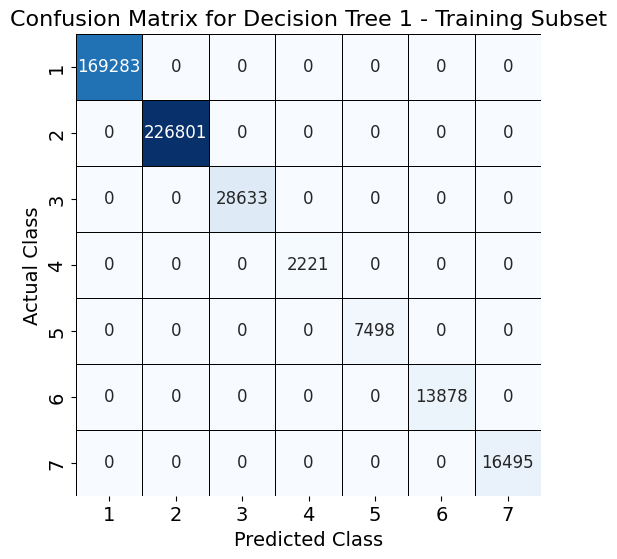

In [128]:
conf_mat_train1 = confusion_matrix(y_train,y_train_pred1)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat_train1, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=dt1.classes_, yticklabels=dt1.classes_, annot_kws={"size": 12})
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for Decision Tree 1 - Training Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

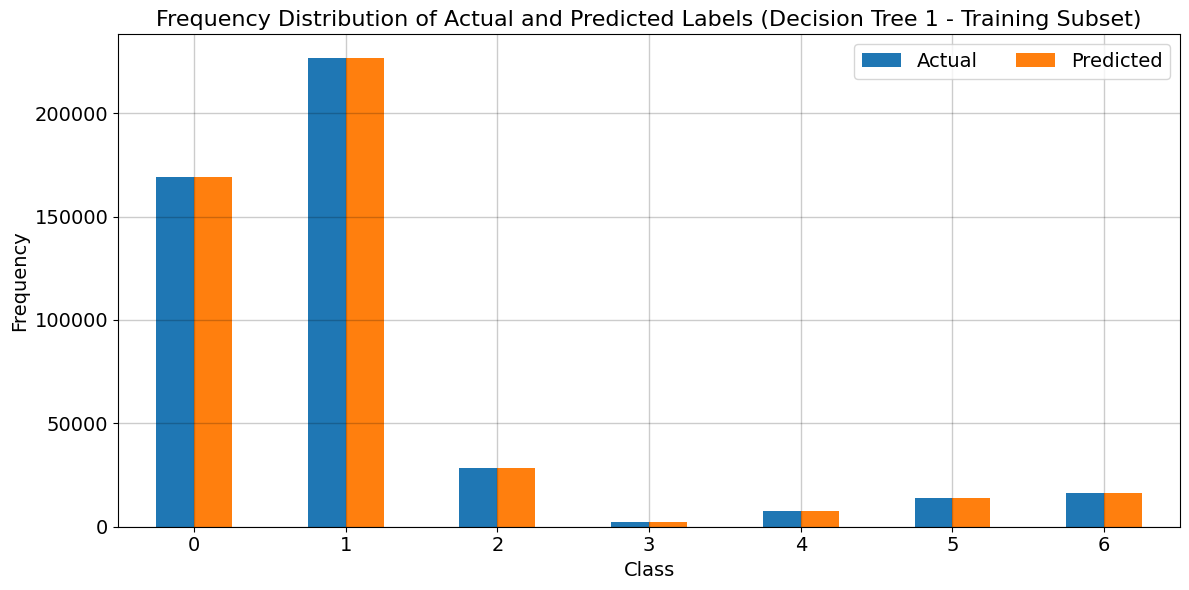

In [129]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_train, actual_counts_train = np.unique(y_train, return_counts=True)
predicted_labels_train1, predicted_counts_train1 = np.unique(y_train_pred1, return_counts=True)

labels_train = np.unique(y_train)

x_train = np.arange(len(labels_train))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_train = ax.bar(x_train - width/2, actual_counts_train, width, label='Actual')
rects2_train = ax.bar(x_train + width/2, predicted_counts_train1, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (Decision Tree 1 - Training Subset)', color='black', fontsize=16)
ax.set_xticks(x_test)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_train) - 0.5]) 
fig.tight_layout()
plt.show()

In [130]:
# Predictions for the test set
y_test_pred1 = dt1.predict(X_test)

In [131]:
# Computing the performance metrics for the test subset
test_accuracy1 = accuracy_score(y_test, y_test_pred1)
test_precision1 = precision_score(y_test, y_test_pred1, average='weighted')
test_recall1 = recall_score(y_test, y_test_pred1, average='weighted')
test_f1_1 = f1_score(y_test, y_test_pred1, average='weighted')

print("Test Accuracy (in %):",round(test_accuracy1*100,3))
print("Test Precision (in %):",round(test_precision1*100,3))
print("Test Recall (in %):",round(test_recall1*100,3))
print("Test F1 Score (in %):",round(test_f1_1*100,3))

Test Accuracy (in %): 94.381
Test Precision (in %): 94.378
Test Recall (in %): 94.381
Test F1 Score (in %): 94.379


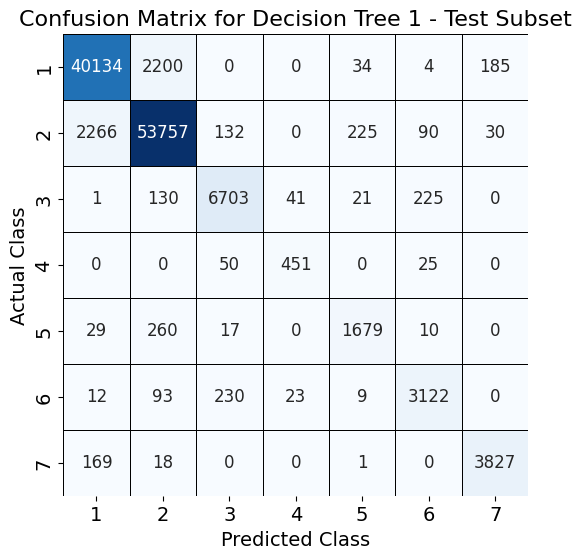

In [132]:
conf_mat_test1 = confusion_matrix(y_test,y_test_pred1)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat_test1, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=dt1.classes_, yticklabels=dt1.classes_, annot_kws={"size": 12})
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for Decision Tree 1 - Test Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

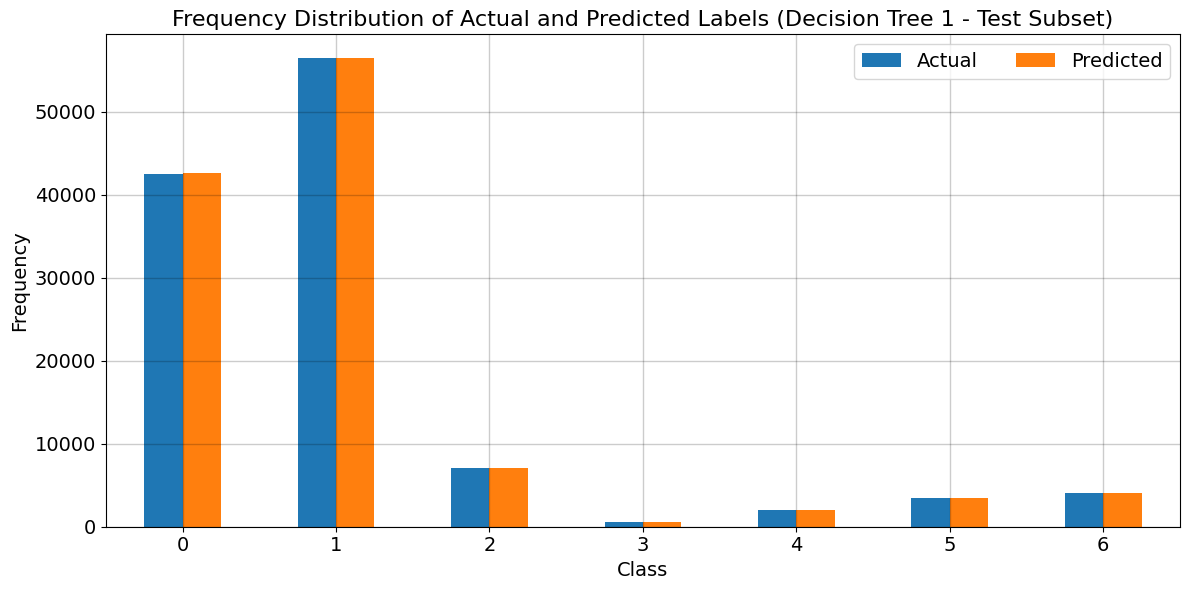

In [133]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_test, actual_counts_test = np.unique(y_test, return_counts=True)
predicted_labels_test1, predicted_counts_test1 = np.unique(y_test_pred1, return_counts=True)

labels_test = np.unique(y_test)

x_test = np.arange(len(labels_test))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_test = ax.bar(x_test - width/2, actual_counts_test, width, label='Actual')
rects2_test = ax.bar(x_test + width/2, predicted_counts_test1, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (Decision Tree 1 - Test Subset)', color='black', fontsize=16)
ax.set_xticks(x_test)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_test) - 0.5]) 
fig.tight_layout()
plt.show()

## Criterion = Gini Index

In [134]:
# Initializing and training the decision tree classifier
dt2 = DecisionTreeClassifier(criterion='gini', random_state=42)
dt2.fit(X_train, y_train)
y_train_pred2 = dt2.predict(X_train)

In [135]:
# Computing the performance metrics for the training subset
train_accuracy2 = accuracy_score(y_train, y_train_pred2)
train_precision2 = precision_score(y_train, y_train_pred2, average='weighted')
train_recall2 = recall_score(y_train, y_train_pred2, average='weighted')
train_f1_2 = f1_score(y_train, y_train_pred2, average='weighted')

print("Training Accuracy (in %):",round(train_accuracy2*100,3))
print("Training Precision (in %):",round(train_precision2*100,3))
print("Training Recall (in %):",round(train_recall2*100,3))
print("Training F1 Score (in %):",round(train_f1_2*100,3))

Training Accuracy (in %): 100.0
Training Precision (in %): 100.0
Training Recall (in %): 100.0
Training F1 Score (in %): 100.0


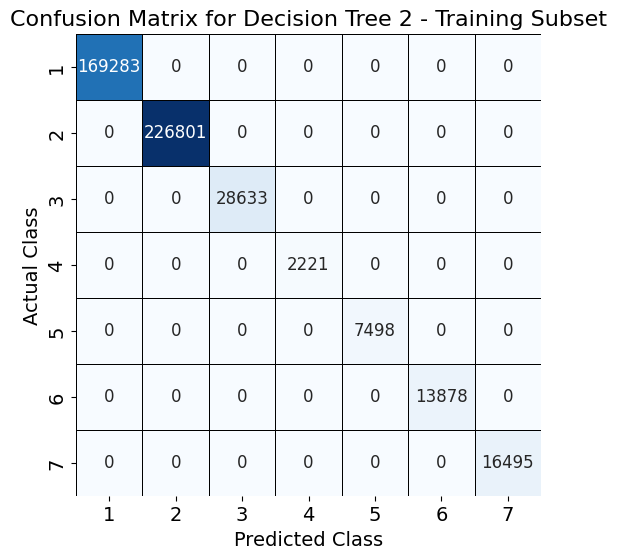

In [136]:
conf_mat_train2 = confusion_matrix(y_train,y_train_pred2)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat_train2, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=dt2.classes_, yticklabels=dt2.classes_, annot_kws={"size": 12})
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for Decision Tree 2 - Training Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

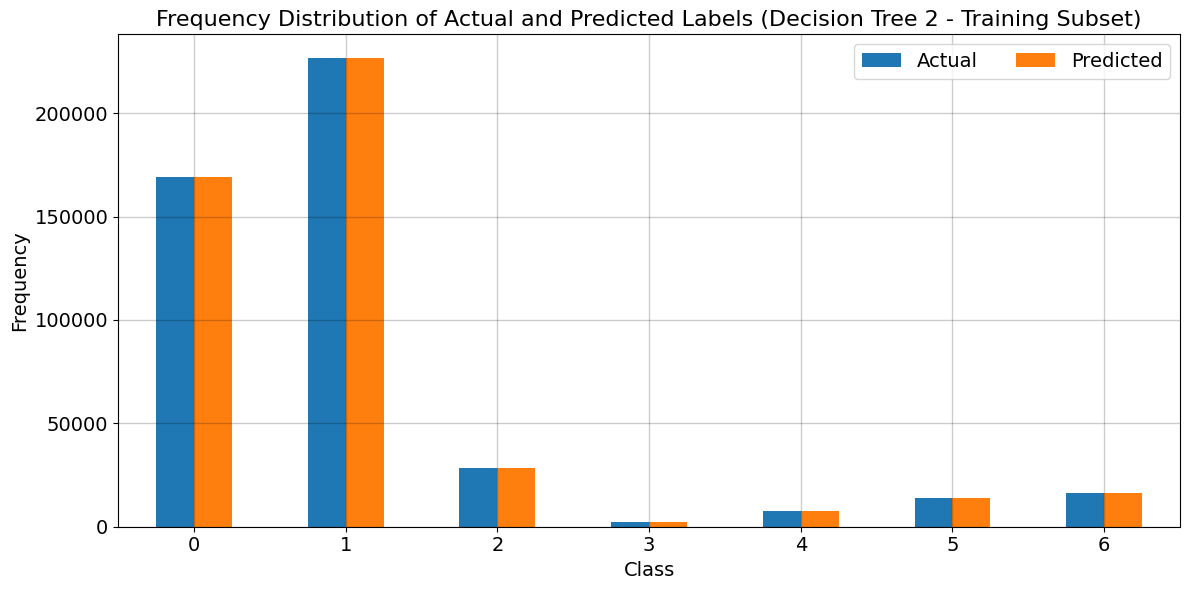

In [137]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_train, actual_counts_train = np.unique(y_train, return_counts=True)
predicted_labels_train2, predicted_counts_train2 = np.unique(y_train_pred2, return_counts=True)

labels_train = np.unique(y_train)

x_train = np.arange(len(labels_train))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_train = ax.bar(x_train - width/2, actual_counts_train, width, label='Actual')
rects2_train = ax.bar(x_train + width/2, predicted_counts_train2, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (Decision Tree 2 - Training Subset)', color='black', fontsize=16)
ax.set_xticks(x_test)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_train) - 0.5]) 
fig.tight_layout()
plt.show()

In [138]:
# Predictions for the test set
y_test_pred2 = dt2.predict(X_test)

In [139]:
# Computing the performance metrics for the test subset
test_accuracy2 = accuracy_score(y_test, y_test_pred2)
test_precision2 = precision_score(y_test, y_test_pred2, average='weighted')
test_recall2 = recall_score(y_test, y_test_pred2, average='weighted')
test_f1_2 = f1_score(y_test, y_test_pred2, average='weighted')

print("Test Accuracy (in %):",round(test_accuracy2*100,3))
print("Test Precision (in %):",round(test_precision2*100,3))
print("Test Recall (in %):",round(test_recall2*100,3))
print("Test F1 Score (in %):",round(test_f1_2*100,3))

Test Accuracy (in %): 93.879
Test Precision (in %): 93.876
Test Recall (in %): 93.879
Test F1 Score (in %): 93.877


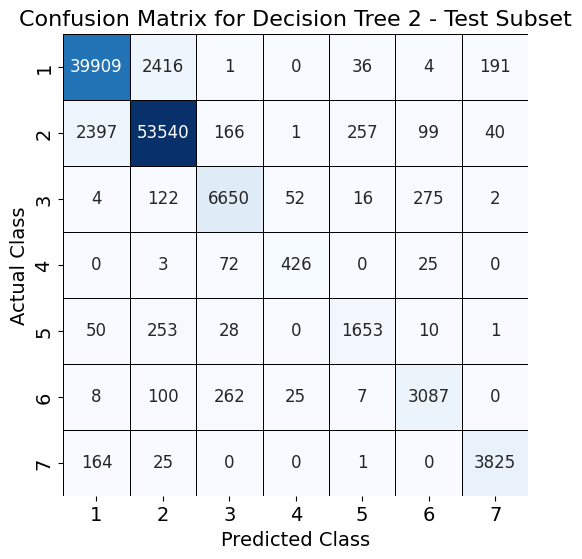

In [140]:
conf_mat2 = confusion_matrix(y_test,y_test_pred2)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat2, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black',
            xticklabels=dt2.classes_, yticklabels=dt2.classes_, annot_kws={"size": 12})
plt.xlabel('Predicted Class', color='black', fontsize=14)
plt.ylabel('Actual Class', color='black', fontsize=14)
plt.title('Confusion Matrix for Decision Tree 2 - Test Subset', color='black', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

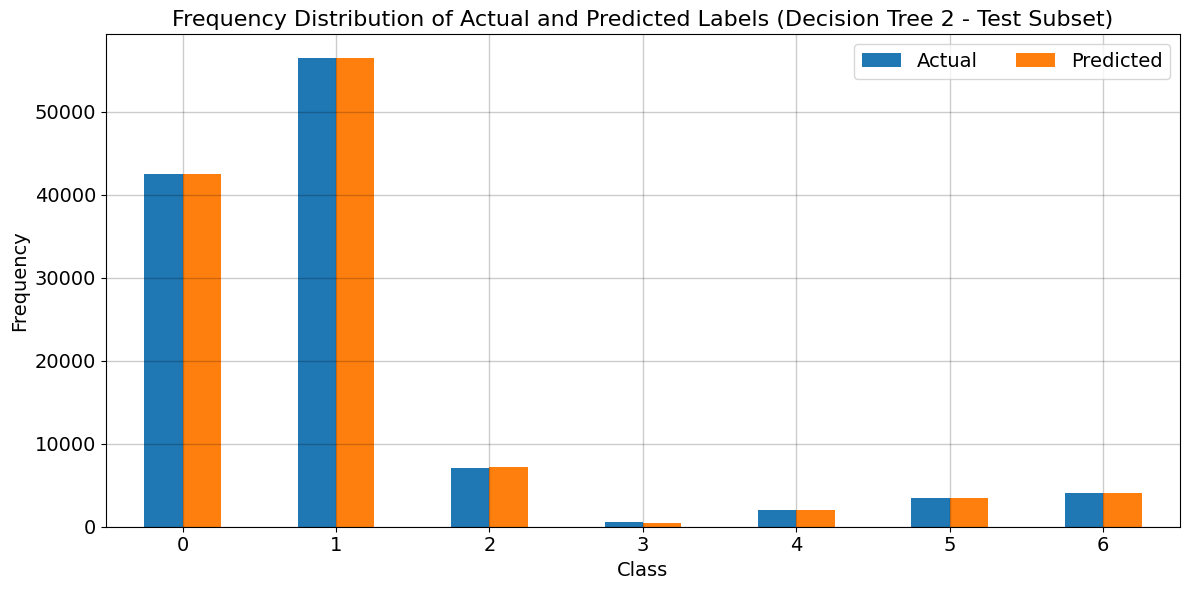

In [141]:
# Plotting the bar graph for frequency distribution of actual and predicted labels (Test Subset)
actual_labels_test, actual_counts_test = np.unique(y_test, return_counts=True)
predicted_labels_test2, predicted_counts_test2 = np.unique(y_test_pred2, return_counts=True)

labels_test = np.unique(y_test)

x_test = np.arange(len(labels_test))
width = 0.25

fig, ax = plt.subplots(figsize=(12,6))
rects1_test = ax.bar(x_test - width/2, actual_counts_test, width, label='Actual')
rects2_test = ax.bar(x_test + width/2, predicted_counts_test2, width, label='Predicted')

ax.set_xlabel('Class', color='black', fontsize=14)
ax.set_ylabel('Frequency', color='black', fontsize=14)
ax.set_title('Frequency Distribution of Actual and Predicted Labels (Decision Tree 2 - Test Subset)', color='black', fontsize=16)
ax.set_xticks(x_test)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14, ncol=2, loc="upper right")
plt.grid(True, linewidth=1, color='black', alpha=0.2)

ax.set_xlim([-0.5, len(labels_test) - 0.5]) 
fig.tight_layout()
plt.show()

***